### Hubble Constant Estimation Notebook

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress
import json

#### Define functions for corrected distances and Hubble fit

In [27]:
def corrected_distances(k, m, M):
    """Calculate corrected distances iteratively."""
    D = 10 ** ((m - M + 5) / 5) / 1e6
    for _ in range(50):
        A_V = k * D
        m_corr = m - A_V
        D = 10 ** ((m_corr - M + 5) / 5) / 1e6
    return D

def hubble_fit(k, m, M, z, c=299792.458):
    """Objective function for Hubble fit."""
    D_corr = corrected_distances(k, m, M)
    v_obs = c * z
    H0, intercept, _, _, _ = linregress(D_corr, v_obs)
    v_pred = H0 * D_corr
    return np.sum(((v_obs) - (v_pred))**2)

def compute_H0(k, m, M, z, c=299792.458):
    """Compute Hubble constant H0."""
    D_corr = corrected_distances(k, m, M)
    v_obs = c * z
    H0, intercept, _, _, _ = linregress(D_corr, v_obs)
    return H0

#### Load data from JSON file

In [28]:
with open('Challenge2_data.json', 'r') as f:
    data = json.load(f)

# Extract data
apparent_magnitude = np.array(data['Apparent Magitude (m)'])
absolute_magnitude = np.array(data['Absolute Magnitude (M)'])
redshift = np.array(data['Redshift (z)'])

#### Define constants and optimize k

In [29]:
c = 299792.458  # Speed of light in km/s
k_initial = 0.0  # Initial guess for k

# Optimize k using minimize
result = minimize(hubble_fit, k_initial, args=(apparent_magnitude, absolute_magnitude, redshift))
k_best = result.x[0]
hess_inv = result.hess_inv
k_error = np.sqrt(hess_inv[0][0])

#### Calculate distances and velocities

In [30]:
D_initial = 10 ** ((apparent_magnitude - absolute_magnitude + 5) / 5) / 1e6
for _ in range(5000):
    A_V = k_best * D_initial
    m_corr = apparent_magnitude - A_V
    D_initial = 10 ** ((m_corr - absolute_magnitude + 5) / 5) / 1e6

Distance_array = D_initial
Velocity_array = redshift * c

#### Perform linear regression and plot results

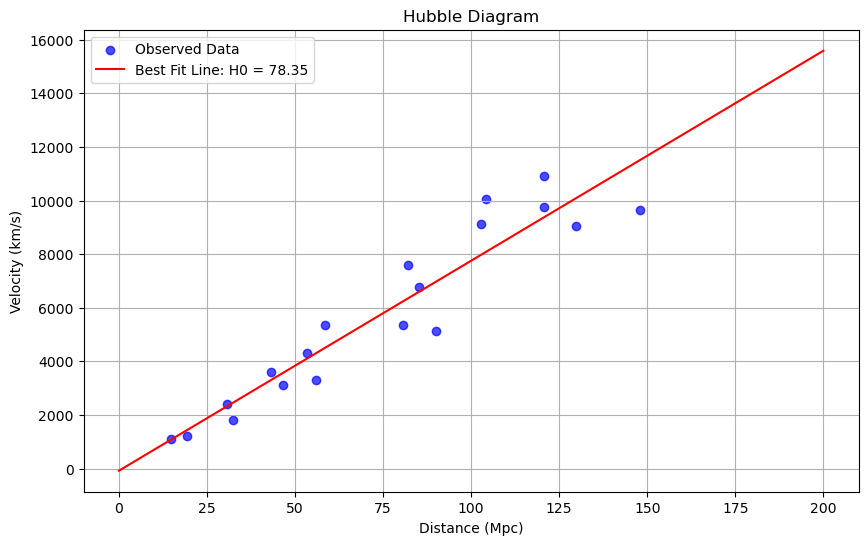

In [31]:
slope, intercept, r_value, p_value, std_err = linregress(Distance_array, Velocity_array)

# Plot results
x = np.linspace(0, 200, 10000)
y = slope * x + intercept

plt.figure(figsize=(10, 6))
plt.scatter(Distance_array, Velocity_array, label='Observed Data', color='blue', alpha=0.7)
plt.plot(x, y, label=f'Best Fit Line: H0 = {slope:.2f}', color='red')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Hubble Diagram')
plt.legend()
plt.grid(True)
plt.show()

####Calculate Time

In [32]:
h = slope
h_inverse = ((1 / h)*3.086e19)/(3600*24*365.2425)
h_inverse_error = (std_err / h)*h_inverse

#### Display results

In [33]:
print(f"H0 = {slope:.4f} ± {std_err:.2f} km/s-Mpc")
print(f"k = {k_best:.4f} mag/Mpc")
print(f"Time = {h_inverse:.4f} ± {h_inverse_error:.4f} Years")

H0 = 78.3474 ± 6.56 km/s-Mpc
k = 0.0033 mag/Mpc
Time = 12481776594.2790 ± 1045651357.6015 Years
